In [2]:
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In this notebook, I will be implementing a Logistic Regression from scratch, just using numpy and the math behind a logistic regression. I will be using the sample Titanic dataset from seaborn and comparing it to the logistic regression model from `statsmodels` to see whether my algorithm works correctly. 

# Data Preparation

In [3]:
# load the Titanic dataset
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# for simplicity, we will use only a subset of the columns - pclass, age, fare, sibsp and parch
X = np.array(titanic[['pclass', 'age', 'fare', 'sibsp', 'parch']].dropna())

# standardize the data 
X_std = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)

# adding a bias term to the model (the statsmodels requires one)
X_sm = sm.add_constant(X_std)

In [5]:
# filtering the target variable based on our independent variables
y = np.array(titanic['survived'][titanic[['pclass', 'age', 'fare', 'sibsp', 'parch']].dropna().index])

In [6]:
# 891 observations, 6 features
X_sm.shape, y.shape

((714, 6), (714,))

# Statsmodels Logistic Regression

In [10]:
# let's take a look at the results of our baseline model, which we want to roughly replicate
model = sm.Logit(y, X_sm)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.570854
         Iterations 6


In [11]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.1548
Time:                        14:58:14   Log-Likelihood:                -407.59
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.848e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4301      0.086     -5.004      0.000      -0.599      -0.262
x1            -0.9658      0.122     -7.900      0.000      -1.205      -0.726
x2            -0.6469      0.105     -6.181      0.000      -0.852      -0.442
x3             0.1742      0.134      1.299      0.194      -0.089       0.437
x4            -0.2716      0.099     -2.755      0.006      -0.465      -0.078
x5             0.2114      0.093      2.273      0.023       0.029       0.394
==============================================================================
"""

# My Implementation

In [14]:
# first we define a function to turn our weights and bias into probabilities using the sigmoid function
def sigmoid(X: np.array, weights: np.array, bias: int):
    probabilities = 1/(1 + np.exp(-(np.dot(X, weights.T) + bias)))
    return probabilities

In [15]:
# defining a predictions function based on our generated probabilities
def predictions(X: np.array, weights: np.array, bias: int):
    probabilities = sigmoid(X, weights, bias)
    predictions = np.round(probabilities)
    return predictions

In [16]:
# define a log loss function here just to track how our log regression is doing over time
def log_loss(y, y_prob):
    m = y.shape[0]
    return (1/m)*np.sum(-y*np.log(y_prob) - (1-y)*np.log(1-y_prob))

In [ ]:
# our choice of algorithm for minimizing the loss function is stochastic gradient descent - as an exercise in the future, can implement multiple algorithms
def stochastic_gradient_descent(y, X, weights, bias, learning_rate):
    # iterate over all the possible data points:
    m = X.shape[0]
    for i in range(m):
        # we select a random X, y tuple from the input data
        random_index = np.random.randint(m)
        X_i = X[random_index]
        y_i = y[random_index]

        # get the initial probabilities based on our weights
        y_prob = sigmoid(X_i, weights, bias)

        # get the gradients of the weights and the bias - based on partial derivatives of log loss (calculated outside this notebook) - these will be the numbers, by which we need to update the weights and bias
        d_weights  = -(y_i - y_prob)*X_i
        d_bias = -(y_i - y_prob)

        weights = weights - learning_rate*d_weights
        bias = bias - learning_rate*d_bias

    return weights, bias


In [18]:
def logistic_regression(X, y, learning_rate = 0.001, n_iterations = 100):
    # first we initialize the weights and bias of our logistic regression model - here I will do 0, but I can also test out random initialization later
    weights = np.zeros(X.shape[1])
    bias = 0

    loss_tracker = []

    # now we loop over the defined number of iterations
    for iteration in range(n_iterations):
        # update the weights and bias using stochastic gradient descent every iteration:
        weights, bias = stochastic_gradient_descent(y, X, weights, bias, learning_rate)

        # calculate the probabilities after each SGD
        y_prob = sigmoid(X, weights, bias)
        loss_tracker.append(log_loss(y, y_prob))
    
    return weights, bias, loss_tracker


In [19]:
weights, bias, loss_tracker = logistic_regression(X_std, y)

<Axes: >

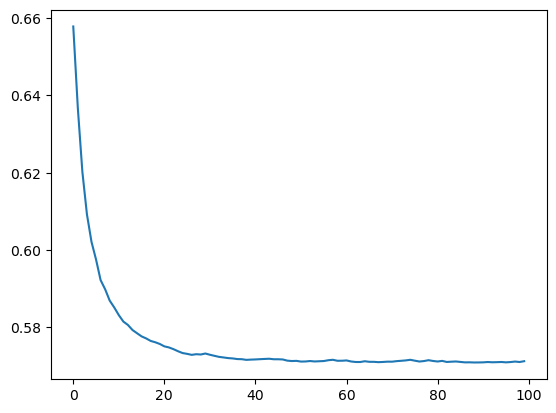

In [20]:
# here we plot our log loss over the iterations/epochs to visualize the convergence
sns.lineplot(loss_tracker)

In [34]:
my_results = np.append(np.array(bias), weights)
my_results

array([-0.45450695, -0.92872329, -0.63991956,  0.14326792, -0.28276259,
        0.19869502])

In [32]:
sm_results = result.params
sm_results

array([-0.43006148, -0.96583151, -0.64693263,  0.17421386, -0.27155985,
        0.21136566])

Comparing the two models, the coefficients are largely comparable. This was overall a success! Some things to note:
- the coefficients change every time the code is run since the stochastic gradient descent chooses a random data point each time - the calculations always change
- I had to decrease the learning rate from the default 0.01, because the log loss results were quite choppy otherwise - with a higher learning rate, there is a smoother curve